In [217]:
from datetime import datetime
import matplotlib.pyplot as plt
import os
import pandas as pd
import sqlite3
from pandas import DataFrame as df
import numpy as np
from pandas import read_csv as rc
import seaborn as sns

def buy_and_sell_entries(ADhandle,BDhandle,df_general=None,signalmatrix=None):
    # df_general is Best Bid Best Ask for both exchanges

    # Our entry and exits
    buyentry=[];sellentry=[]

    # Enter the first buy (Index is zero indexed)
    open_signal = signalmatrix['AskDiff']< -ADhandle
    first_entry_idx = df_general[open_signal].head(1).index.values
    buyentry.append(first_entry_idx)

    # Enter the first close
    close_signal = signalmatrix['BidDiff']>BDhandle
    first_close_signal = df_general[close_signal] 
    first_close_idx = first_close_signal[first_close_signal.index.values > first_entry_idx].head(1).index.values
    sellentry.append(first_close_idx)

    more_oppurtunities = lambda: len(sellentry[-1])!=0
    trade_initated = lambda: len(buyentry[-1])!=0
    
    while more_oppurtunities():
        next_open_signal = df_general[open_signal]
        next_open_idx = next_open_signal[next_open_signal.index.values > sellentry[-1]].head(1).index.values
        buyentry.append(next_open_idx)
        
        if trade_initated():
            next_close_signal = df_general[close_signal] 
            next_close_idx = next_close_signal[next_close_signal.index.values > next_open_idx].head(1).index.values
            sellentry.append(next_close_idx)
        else:
            break

    # Cleanup the mess 
    for i in [sellentry, buyentry]:
        if len(i[-1])==0:
            i.pop(-1)

    return [buyentry, sellentry]

def trading_plugin(buysellentries):
    [buyentry,sellentry]=buysellentries
    Entries=df(buyentry).join(df(sellentry),rsuffix='r')
    Entries.columns=['B','S']

    if len(buyentry)>len(sellentry):
        Entries=Entries.iloc[:(Entries.shape[0]-1),]

    RoT=[None]*(Entries.shape[0])

    for i in range(Entries.shape[0]):
        buyprice=df_general.loc[Entries['B'][i]]['lAsk'] 
        sellprice=df_general.loc[Entries['S'][i]]['lBid']
        RoT[i]=sellprice/buyprice

    Entries_in_time=df(df_general.loc[Entries['B']]['Time']).reset_index(
    drop=True).join(df(df_general.loc[Entries['S']]['Time']).reset_index(drop=True),rsuffix='S')

    Entries_in_time.columns=Entries.columns

    return [Entries_in_time, RoT]



In [238]:
df_general=rc('merged_large_2_sec.csv')
from functools import reduce
from tqdm import tqdm

In [239]:
#Housekeeping
df_general = df_general.ffill()
signalmatrix = df(df_general['lBid']-df_general['kBid'])
signalmatrix = signalmatrix.join(df(df_general['lAsk']-df_general['kAsk']),rsuffix='r')
(signalmatrix).columns=('BidDiff','AskDiff')


sharpes = np.zeros((21,21))
sortinos = np.zeros((21,21))
n_trades = np.zeros((21,21))
return_curves = []

pbar = tqdm(16 * 16)
for i in range(5,21):
    for j in range(5,21):
        pbar.update(1)
        timeindf, RoT = trading_plugin(buy_and_sell_entries(i,j,df_general, signalmatrix))

        #In case you fancy
        timeindf['RoT']=RoT

        mean_returns = (timeindf['RoT'] -1).mean()
        std_returns = (timeindf['RoT']-1).std() 

        std_returns_neg = (timeindf['RoT']-1)[timeindf['RoT']-1 < 0].std() 


        sharpe = mean_returns / std_returns
        sortino = mean_returns / std_returns_neg
        sharpes[i,j], sortinos[i,j], n_trades[i,j] = sharpe, sortino, len(RoT)
        
        curve = []
        for k in range(len(RoT)):
            curve.append(reduce(lambda left, right: left*right ,RoT[:k+1]))
        
        return_curves.append((curve, i,j))

# res = buy_and_sell_entries(20,10,df_general, signalmatrix)

256it [00:50, 10.33it/s]

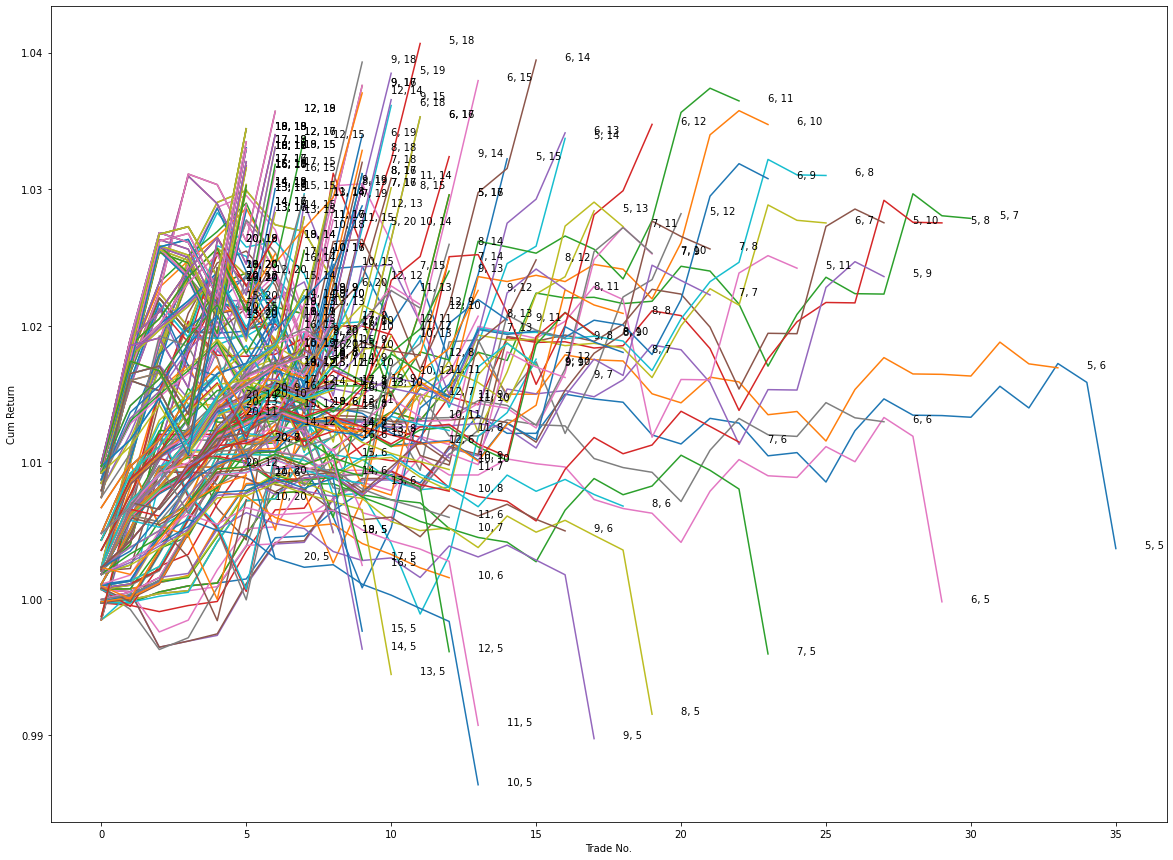

In [240]:
plt.figure(figsize=(20,15))
for i in range(len(return_curves)):
    curve = return_curves[i][0]
    plt.plot(curve)
    plt.annotate(s="%s, %s" % (return_curves[i][1],return_curves[i][2]), xy=(len(curve), curve[-1]))
    plt.xlabel('Trade No.')
    plt.ylabel('Cum Return')

Text(159.0, 0.5, 'ask_thres')

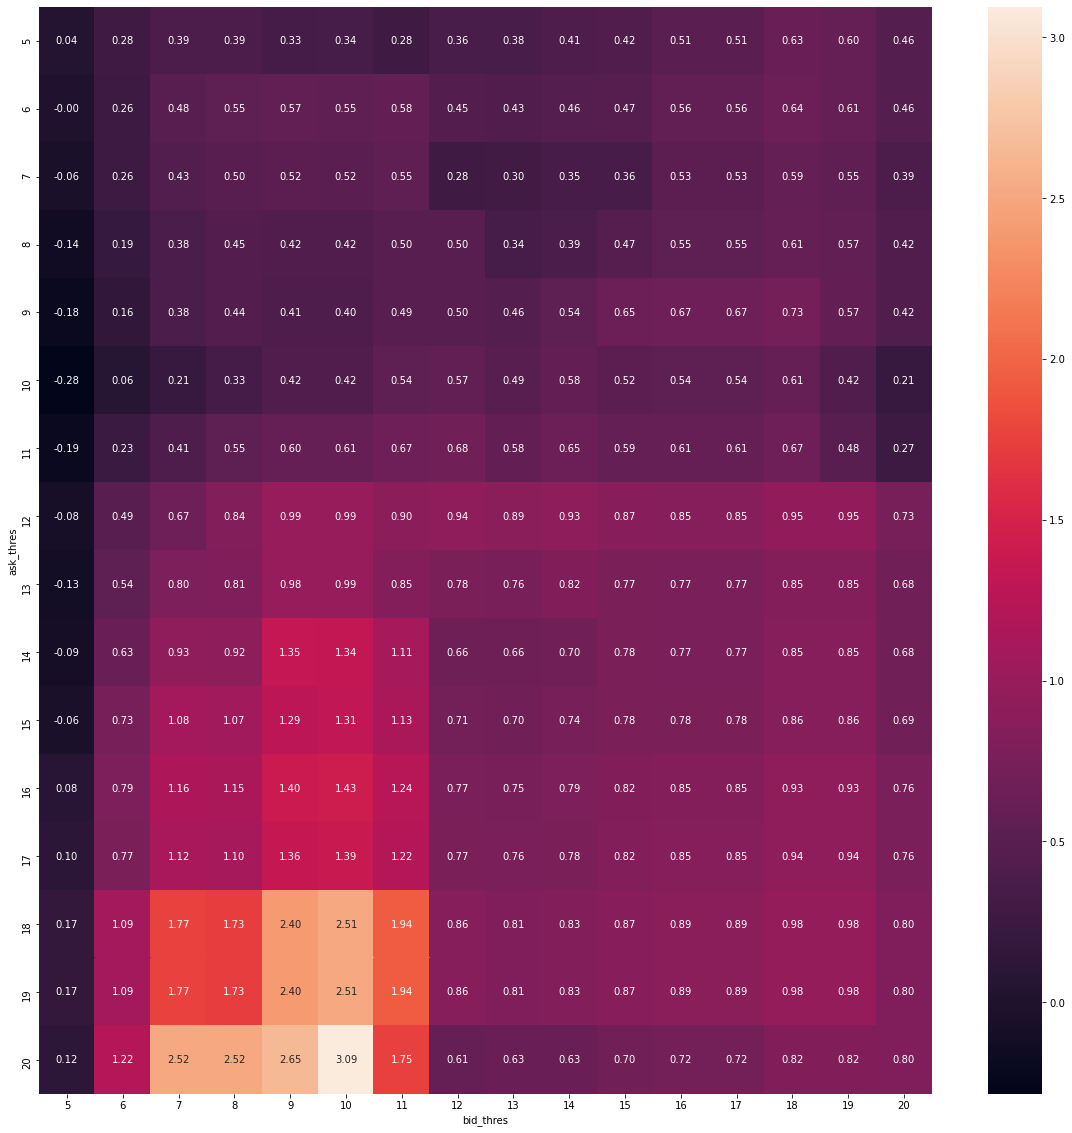

In [241]:
plt.figure(figsize=(20,20))
sns.heatmap(sharpes[5:,5:], xticklabels=np.arange(5,21),yticklabels=np.arange(5,21), annot=True,   fmt='.2f')
plt.xlabel('bid_thres')
plt.ylabel('ask_thres')

Text(159.0, 0.5, 'ask_thres')

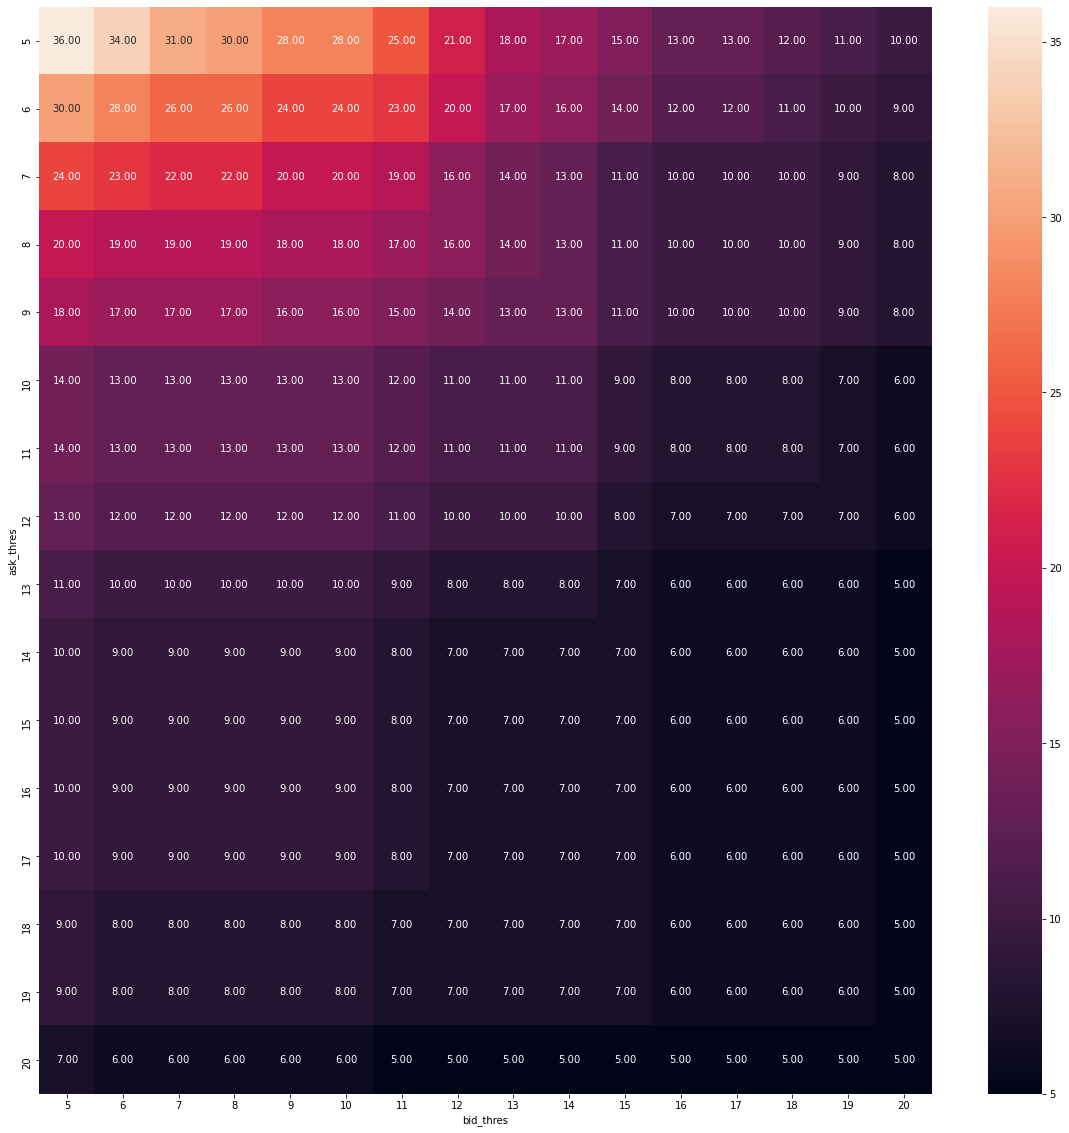

In [242]:
plt.figure(figsize=(20,20))
sns.heatmap(n_trades[5:,5:], xticklabels=np.arange(5,21),yticklabels=np.arange(5,21), annot=True,   fmt='.2f')
plt.xlabel('bid_thres')
plt.ylabel('ask_thres')

In [243]:
spread_l, spread_k = df_general['lAsk'] - df_general['lBid'], df_general['kAsk'] - df_general['kBid']

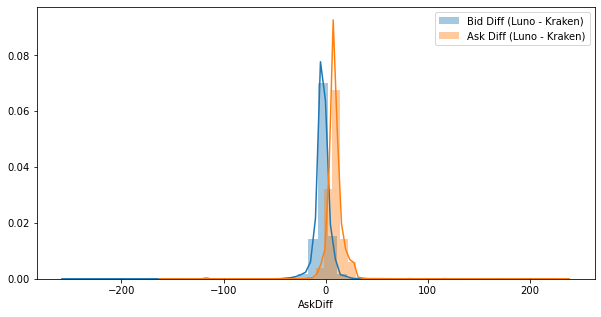

In [244]:
plt.figure(figsize=(10,5)) 
sns.distplot(signalmatrix['BidDiff'], label='Bid Diff (Luno - Kraken)') # Luno Bid is typically lower than bitstamp 
sns.distplot(signalmatrix['AskDiff'], label='Ask Diff (Luno - Kraken)') # Luno Ask is typically higher than bitstamp
# -> Higher spread on Luno. but the spread is more on ask side than the bid side
plt.legend()

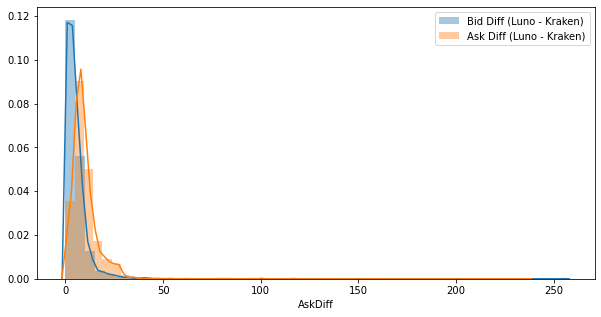

In [245]:
plt.figure(figsize=(10,5)) 
sns.distplot(signalmatrix['BidDiff'].abs(), label='Bid Diff (Luno - Kraken)') # Luno Bid is typically lower than bitstamp 
sns.distplot(signalmatrix['AskDiff'].abs(), label='Ask Diff (Luno - Kraken)') # Luno Ask is typically higher than bitstamp
# -> Higher spread on Luno. but the spread is more on ask side than the bid side
plt.legend()

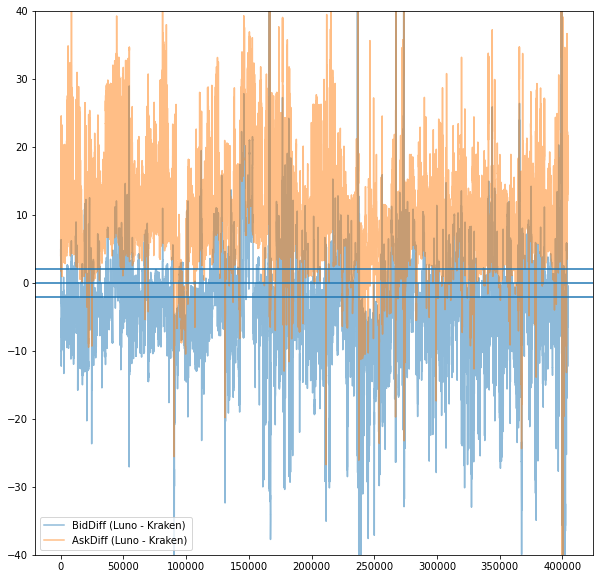

In [253]:
plt.figure(figsize=(10,10))
plt.plot(signalmatrix['BidDiff'], alpha=0.5, label='BidDiff (Luno - Kraken)')
plt.plot(signalmatrix['AskDiff'], alpha=0.5, label='AskDiff (Luno - Kraken)')
plt.ylim(-40,40)
plt.axhline(0)
plt.axhline(2)
plt.axhline(-2)
plt.legend()

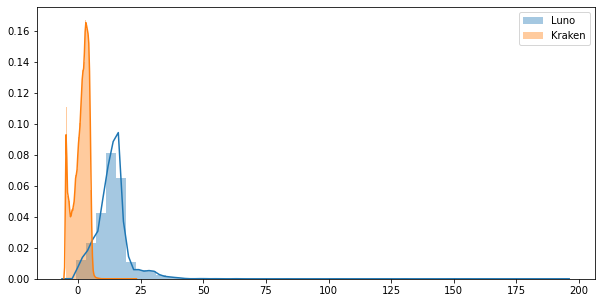

In [247]:
plt.figure(figsize=(10,5)) 
sns.distplot(spread_l, label='Luno')
sns.distplot(spread_k, label='Kraken')
plt.legend()

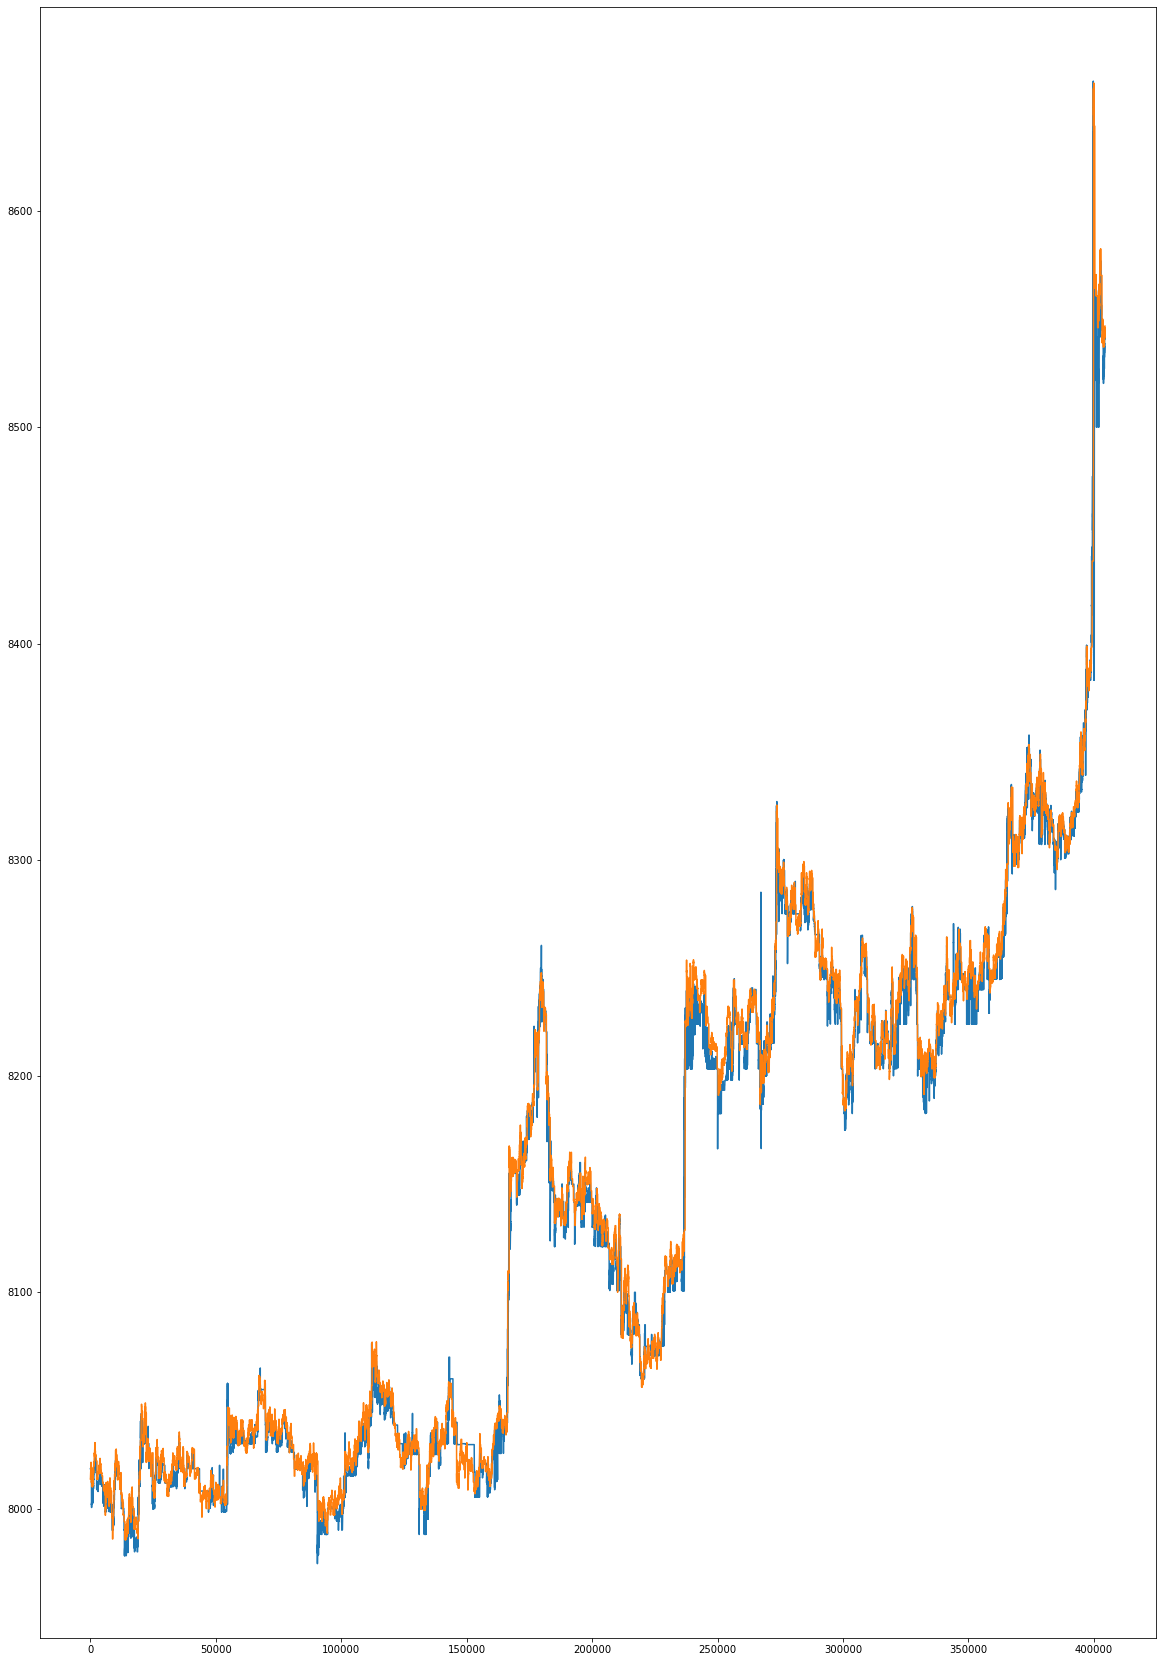

In [252]:
plt.figure(figsize=(20,30))
plt.plot(df_general['lBid'])
plt.plot(df_general['kBid'])
